In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time

!cp /content/drive/MyDrive/python/cpt-mect/cpt-tutorial/input/data.zip .
!unzip data.zip -d input/

Archive:  data.zip
   creating: input/train/
  inflating: input/train/8cdc80fc.csv  
  inflating: input/train/6e384c89.csv  
  inflating: input/train/bf9a8aaa.csv  
  inflating: input/train/2ab6da44.csv  
  inflating: input/train/aed2a182.csv  
  inflating: input/train/ae895067.csv  
  inflating: input/train/b1323651.csv  
  inflating: input/train/e003c508.csv  
  inflating: input/train/bc29200d.csv  
  inflating: input/train/dbbc3dda.csv  
  inflating: input/train/7acd3122.csv  
  inflating: input/train/5447da22.csv  
  inflating: input/train/ae7b3b91.csv  
  inflating: input/train/3dfa92db.csv  
  inflating: input/train/dae22c36.csv  
  inflating: input/train/0794a222.csv  
  inflating: input/train/4b865c28.csv  
  inflating: input/train/54b4a4d8.csv  
  inflating: input/train/11366505.csv  
  inflating: input/train/7489701c.csv  
  inflating: input/train/d942af57.csv  
  inflating: input/train/c65f90bc.csv  
  inflating: input/train/06649ef2.csv  
  inflating: input/train/250bba67.c

```
../input
├── sample_submission.csv
├── test
│     ├── xxx.csv
│     └── xxx.csv
├── train
│     ├── xxx.csv
│     └── xxx.csv
└── train_meta.csv
```

In [ ]:
!mkdir work
%cd work

/content/work


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from glob import glob
from matplotlib import pyplot as plt

import seaborn as sns

import os, random, gc
import re, time, json
from  ast import literal_eval

import joblib

from  sklearn.model_selection  import StratifiedKFold

from IPython.display import Image, clear_output 

from sklearn.metrics import label_ranking_average_precision_score
from sklearn.preprocessing import LabelEncoder

from scipy.misc import derivative
from sklearn.metrics import precision_recall_curve, auc

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter('ignore')

import random
import lightgbm as lgb
import pickle

from glob import glob

from joblib import Parallel, delayed

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

sns.set(style="darkgrid")

In [ ]:
MODEL_CHECKPOINT_DIR = Path("/content/drive/MyDrive/python/cpt-mect/cpt-tutorial/baseline_rule_center/")
ROOT_DIR = Path("/content/input/")

if not MODEL_CHECKPOINT_DIR.exists():
    MODEL_CHECKPOINT_DIR.mkdir()

In [ ]:
df_meta = pd.read_csv(Path(ROOT_DIR/ "train_meta.csv"))

center_csv_paths = [str(x) for x in list( ROOT_DIR.glob("train/*.csv") )]
files = [x.split("/")[-1] for x in center_csv_paths]

df_csv = pd.DataFrame({
    "filename":files,
    "filepath":center_csv_paths,
})

df_meta = pd.merge(df_meta,df_csv, on="filename", how="left")
df_meta

,filename,scratchpos_edge,scratchpos_center,scratchpos_baffle,filepath
0,000a849f.csv,NaN,NaN,NaN,/content/input/train/000a849f.csv
1,000bd931.csv,NaN,NaN,NaN,/content/input/train/000bd931.csv
2,001bd932.csv,NaN,NaN,15626 15668,/content/input/train/001bd932.csv
3,0029d521.csv,NaN,NaN,10937 10974,/content/input/train/0029d521.csv
4,00338f0c.csv,NaN,NaN,NaN,/content/input/train/00338f0c.csv
...,...,...,...,...,...
1421,ff037a09.csv,NaN,NaN,NaN,/content/input/train/ff037a09.csv
1422,ff9089ae.csv,NaN,NaN,NaN,/content/input/train/ff9089ae.csv
1423,ffac61bb.csv,6883 6981,NaN,NaN,/content/input/train/ffac61bb.csv
1424,ffea37c0.csv,NaN,NaN,9604 9630,/content/input/train/ffea37c0.csv


In [ ]:
# スペース区切りの傷位置アノテーションをintの配列に変更
# 傷1スタート、傷1エンド、傷2スタート、傷2エンド、、、というフォーマットなので配列のlenは必ず偶数になる
# 傷の個数をカウントしやすいように NaNを[]で置き換える
df_meta["scratchpos_edge"] = df_meta["scratchpos_edge"].apply( lambda x: [int(y) for y in x.split()] if not pd.isna(x) else [])
df_meta["scratchpos_center"] = df_meta["scratchpos_center"].apply( lambda x: [int(y) for y in x.split()] if not pd.isna(x) else [])
df_meta["scratchpos_baffle"] = df_meta["scratchpos_baffle"].apply( lambda x: [int(y) for y in x.split()] if not pd.isna(x) else [])

df_meta["num_edge"] = df_meta["scratchpos_edge"].apply( lambda x: int(len(x) / 2))
df_meta["num_center"] = df_meta["scratchpos_center"].apply( lambda x: int(len(x) / 2))
df_meta["num_baffle"] = df_meta["scratchpos_baffle"].apply( lambda x: int(len(x) / 2))

df_meta["num_all"] = df_meta["num_edge"] + df_meta["num_center"] + df_meta["num_baffle"]

def merge_scratch(row):
    
    merged_pos = row["scratchpos_edge"] + row["scratchpos_center"] + row["scratchpos_baffle"]
    merged_pos.sort()

    return merged_pos

df_meta["scratchpos_all"] = df_meta.apply(merge_scratch, axis=1)
df_meta

,filename,scratchpos_edge,scratchpos_center,scratchpos_baffle,filepath,num_edge,num_center,num_baffle,num_all,scratchpos_all
0,000a849f.csv,[],[],[],/content/input/train/000a849f.csv,0,0,0,0,[]
1,000bd931.csv,[],[],[],/content/input/train/000bd931.csv,0,0,0,0,[]
2,001bd932.csv,[],[],"[15626, 15668]",/content/input/train/001bd932.csv,0,0,1,1,"[15626, 15668]"
3,0029d521.csv,[],[],"[10937, 10974]",/content/input/train/0029d521.csv,0,0,1,1,"[10937, 10974]"
4,00338f0c.csv,[],[],[],/content/input/train/00338f0c.csv,0,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...
1421,ff037a09.csv,[],[],[],/content/input/train/ff037a09.csv,0,0,0,0,[]
1422,ff9089ae.csv,[],[],[],/content/input/train/ff9089ae.csv,0,0,0,0,[]
1423,ffac61bb.csv,"[6883, 6981]",[],[],/content/input/train/ffac61bb.csv,1,0,0,1,"[6883, 6981]"
1424,ffea37c0.csv,[],[],"[9604, 9630]",/content/input/train/ffea37c0.csv,0,0,1,1,"[9604, 9630]"


## ルールべース判定
管中央部に限り以下のルールを元に傷の判定を行っております。  
以下の条件の AND が成立したときに傷と判定します。
* MIX1-Yが250以上 
* MIX1-Xのある一定区間で見たときのpeak-to-peakの差が250以上 
* 山が先に来たとき  (谷が先のときは傷と判定しない)
* peak-to-peakが50sec以内 (0.1secサンプリングなのでcsv500レコードが50secとなる)

ルールベースである程度傷の判定を行うことは可能ですが、完璧ではないです。  

管中央部以外の、バッフル部・管端部に関してはルールは明示化できておらず、資格者が目視で判定しております。   
バッフル部に関しては以下のパターンに分解できることがわかっております。

(以下はEddyCurrentTesting_Explanation.pdfからの抜粋)

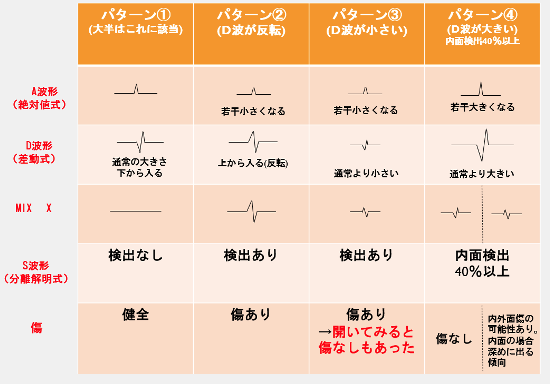

In [ ]:
def rulebase_model(df, th):

    duration = 300 # peak-to-peakの差が250以上を判定するときの区間 ※ここの300は改善の余地あり
    df_all = df.reset_index(drop=False).copy()

    upper_start_pos = []
    upper_end_pos = []

    true_start_scratch_pos = []
    true_end_scratch_pos = []
    
    df[target2] = df[target2] - df[target2].min()
    
    df = df[(df[target1]>th) & (df[target2]>th)]

    if len(df)==0:
        return [], []

    df = df.reset_index(drop=False)

    df["diff"] = df["index"].diff(1)
    
    ### diffが全部1のとき 
    if df["diff"].sum() == len(df["diff"]) -1:
        upper_start_pos = df.index.values[:1]
        upper_end_pos = df.index.values[-1:]

        upper_start_pos = df.loc[upper_start_pos,"index"].values
        upper_end_pos = df.loc[upper_end_pos,"index"].values

    else:

        if df[df["diff"]!=1].index[-1]==len(df)-1:
            upper_start_pos = df[df["diff"]!=1].index
            upper_end_pos = (upper_start_pos -1)[1:] 
            upper_start_pos = upper_start_pos[:-1]

        else:
            upper_start_pos = df[df["diff"]!=1].index
            upper_end_pos = (upper_start_pos -1)[1:]
            upper_end_pos = np.append(upper_end_pos, upper_start_pos[-1]+1)  

        upper_start_pos = df.loc[upper_start_pos,"index"].values
        upper_end_pos = df.loc[upper_end_pos,"index"].values

    for i, idx in enumerate(upper_start_pos):

        start = idx 
        end = idx + duration

        tmp = df_all[(df_all["index"]>start) & (df_all["index"]<end)]
    
        # MIX1-Yにおいて逆側ブレ -250以下になるパターンを検知
        # この-250の判定を入れないと検出箇所が多くなりすぎる
        if len(tmp[tmp[target1]<-th]) > 0:
            
            #区間の最大値、最小値を取得。s が eよりも小さくなるように。
            s = tmp[tmp[target1] == tmp[target1].max()]["index"].values[-1]
            e = tmp[tmp[target1] == tmp[target1].min()]["index"].values[-1]

            ### startをminより左側indexでかつ、maxの位置にする。 mixより左側を指定しないと、右側のmaxを拾ってしまうため
            tmp2 = tmp[tmp["index"]<e]
            s = tmp2[tmp2[target1] == tmp2[target1].max()]["index"].values[-1]

            swap=0
            if s > e:
                swap =s
                s = e
                e = swap

            buf = 10
            check_mix1x_gap = df_all[(df_all["index"]>s-buf) & (df_all["index"]<e+buf)]
            
            mix1x_max = check_mix1x_gap[target2].max()
            mix1x_min = check_mix1x_gap[target2].min()

            mix1x_max_pos = check_mix1x_gap[check_mix1x_gap[target2] == mix1x_max]["index"].values[-1]
            mix1x_min_pos = check_mix1x_gap[check_mix1x_gap[target2] == mix1x_min]["index"].values[-1]

            f_50m = 0
            f_mix1x250 = 0
            f_mix1x_maxstart = 0
            f_mix1x_fewchgpoint = 0

            if np.abs(s-e)<=500:   ### ピークtoピーク 50msec以内 
                f_50m = 1
            else:
                None
                #print("false ピークtoピーク 50msec以内  :  ",s,e)

            if mix1x_max - mix1x_min>=250 :   ### MIX1-X MAX-MIN>250
                f_mix1x250 = 1
            else:
                None
                #print("false MIX1-X MAX-MIN>250  :  ",s,e)
                #print(f"false MIX1-X ::{mix1x_max} , MAX-MIN ::{mix1x_min}  :  ")

            if mix1x_max_pos<mix1x_min_pos:  ### 山が先に来たときのみ傷とする。　谷が先のときは傷と判定しない
                f_mix1x_maxstart = 1
            else:
                None
                #print("false 山が先に来たときのみ傷とする  :  ",s,e)

            if (f_50m==1) & (f_mix1x250==1) & (f_mix1x_maxstart==1):
                true_start_scratch_pos.append(s)
                true_end_scratch_pos.append(e)
            else:
                None
        else:
            None

    return true_start_scratch_pos, true_end_scratch_pos

def get_center_ids(df_, target="MIX1-Y",  th=7500, margin=1000):
    """
    管端部、管中央部の境目のidを取得する。 管端部は入り口、出口と2つあるので、2つの境目を取得。
    ※管端部、管中央部の境目の明確な定義は存在せず、Trainデータを可視化して目視でルールを決定した
    
    管端部の検出用の大きい閾値と、管中央部の最大値程度の小さい閾値の2種類使って判定を行う。

    Parameters
    --------------
    df_ : DataFrame
        スペクトルデータ
    target : str
        DataFrameのcolumns名
    th : int
        管端部の検出用の閾値
    margin : int
        管端部の検出用の閾値から、margin分管端部領域を拡大する。

    Returns
    ----------
    s_center : int
        管中央部の開始位置
    e_center : int
        管中央部の終了位置
    """
    harf_pos = int(len(df_)/2)
    
    first_th = -th
    last_th = th

    df_first = df_[:harf_pos]
    first_ids = df_first[df_first[target]< first_th].index
    
    if len(first_ids) == 0:
        first_ids = df_first[df_first[target]< first_th*0.2 ].index

    first_max = first_ids.max()
    
    s_center = first_max + margin

    df_last = df_[harf_pos:]
    last_ids = df_last[df_last[target]> last_th].index
    
    if len(last_ids) == 0:
        last_ids = df_last[df_last[target]> last_th*0.2 ].index
    
    last_min = last_ids.min()
    
    e_center = last_min - margin

    return s_center, e_center

In [ ]:
target1 = "MIX1-Y"
target2 = "MIX1-X"

In [ ]:
csv_paths = [str(x) for x in list( ROOT_DIR.glob("test/*.csv") )]
files = [x.split("/")[-1] for x in csv_paths]

test_csv = pd.DataFrame({
    "filename":files,
    "filepath":csv_paths,
})

In [ ]:
sample_submission = pd.read_csv(f"{str(ROOT_DIR)}/sample_submission.csv")

管中央部だけでsubmissionを作成する  
※管端部のpredictionは行えていないので注意

In [ ]:
filepaths = test_csv["filepath"].values
filenames = test_csv["filename"].values

tq_ = tqdm(zip(filepaths,filenames), total=len(filepaths))

sub_preds=[]
sub_ids=[]

for i,(path,name) in enumerate(tq_):
    filename = path.split("/")[-1]
    test = pd.read_csv(path)
    name = name[:-4]
    
    test = test.reset_index(drop=False).rename(columns={"index":"pos"})
    test["target"] = 0

    center_start, center_end = get_center_ids(test)
    
    #rule_starts , rule_ends = rulebase_model(df.loc[center_start:center_end], th=250)
    rule_starts , rule_ends = rulebase_model(test, th=250)

    for rule_start , rule_end in zip(rule_starts , rule_ends):
        test.loc[(test["pos"]>=rule_start) & (test["pos"]<=rule_end) ,"target"] = 1

    test_pred = test["target"].values

    num_50 = len(sample_submission[sample_submission["id"].str.contains(name)])

    sub_ids = sub_ids + [name+ "_" +str(50*(x+1)) for x in range(num_50)]
    sub_preds = sub_preds + [test_pred[50*x:50*(x+1)].max() for x in range(num_50)]


  0%|          | 0/1458 [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame({
    "id":sub_ids,
    "target":sub_preds
})
submission

,id,target
0,0f6ba65c_50,0
1,0f6ba65c_100,0
2,0f6ba65c_150,0
3,0f6ba65c_200,0
4,0f6ba65c_250,0
...,...,...
11608,cc2a2cd7_54400,0
11609,cc2a2cd7_54450,0
11610,cc2a2cd7_54500,0
11611,cc2a2cd7_54550,0


In [ ]:
submission = pd.DataFrame({
    "id":sub_ids,
    "target":sub_preds
})

submission.to_csv(f"{str(MODEL_CHECKPOINT_DIR)}submission.csv" ,index=False)

sample_submission = pd.merge(sample_submission[["id"]], submission, on="id", how="left" )

sample_submission.to_csv(f"{str(MODEL_CHECKPOINT_DIR)}/submission_sample.csv" ,index=False)

### EOF